In [114]:
import socket
import sys
import os
from pathlib import Path
import pandas as pd
import time
from datetime import datetime 
from itertools import combinations_with_replacement
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


# Section 1: Set up DroneLab.java

## 1) Copy DroneLab into your home directory

In [146]:
# Set up home directory and move dronelab
new_directory =os.getenv("HOME")+"/dronelab"

## 2) Configure initial experiment parameters, such as the # of Drones

In [149]:
# Set up and configure experiment by modifying the Simulation Matrix File
sim_matrix_dir =new_directory+"/input/Simulation_Matrix.xlsx"
sim_df = pd.read_excel(sim_matrix_dir)

In [150]:
#View simulation matrix
sim_df.head()

#in batch one, there are 12 relay drones, 12 spiral drones and 0 anti-social drones,for a total of 24 drones
#Social Drone definition: Drone with Form and Spiral behaviors
#Relay Drone definition: Drones with Relay behaviors
#Anti-social drone definition: Drones with Spiral and AntiSocial behaviors

#All drones are given a set of behaviors in this priority:
#Launch, Avoid, Climb, Recharge, Maintain Height, Spiral, Relay, Form, AntiSocial, Repel, Seek, Scatter, AssignedPath, Search, Wander

#Most drones already start up with the Launch, Avoid, Climb and Recharge behaviors
#


,Simulation,Batch ID,Relay,Social,Antisocial,Total,WiFi Range
0,1,1,30,20,10,60,0.475


## 3) Launch DroneLab in a new terminal

In [151]:
#Find a free and open port 8000–8999
Port_To_Test = 8007

testSocket = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
location = ('localhost', Port_To_Test)
result_of_check = testSocket.connect_ex(location)
if result_of_check == 0:
    print("Port is open")
else:
    print("Port is NOT open")

Port is open


Launch drone lab code in a new terminal. Replace /home/mosi in 1a & 1b with your own home directory

1a. cd into $HOME/dronelab directory and make sure the code is compiled: /home/mosi/utils/jdk1.8.0_291/bin/javac @options_nix @classes

1b. Specify the free port in the -Dport variable below and run: /home/mosi/utils/jdk1.8.0_291/bin/java -Dport=8007 -Dfile.encoding=UTF8 -Xmx128G -d64 -cp "ext-master/netty-all-4.1.7.Final.jar:ext-master/commons-collections4-4.2.jar:ext-master/commons-compress-1.18.jar:ext-master/curvesapi-1.05.jar:ext-master/drive:ext-master/javax.json-1.0.4.jar:ext-master/javax.json-api-1.0.jar:ext-master/javax.servlet-api-3.1.0.jar:ext-master/poi-4.0.1.jar:ext-master/poi-examples-4.0.1.jar:ext-master/poi-excelant-4.0.1.jar:ext-master/poi-ooxml-4.0.1.jar:ext-master/poi-ooxml-schemas-4.0.1.jar:ext-master/poi-scratchpad-4.0.1.jar:ext-master/xmlbeans-3.0.2.jar:ext-master/jfxrt.jar:ext-master/javax.json-api-1.0.jar:/home/mosi/dronelab/bin:/home/mosi/utils/jdk1.8.0_291/bin/jre:/home/mosi/ext-master/*:." dronelab.DroneLab

You should see the dronelab gui pop up.


## 4) Connect to your DroneLab instance from Python

In [ ]:
# Create a TCP/IP socket
sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)

# Connect the socket to the port where the server is listening
server_address = ('localhost', Port_To_Test)
print(sys.stderr, 'connecting to %s port %s' % server_address)

sock.connect(server_address)

# Section 2 - Base RL experiment

Agent: Assigns roles to drones in the swarm. A DQN is used, where a neural network is used to approximate the action-value function

Environment: DronmeLab. Currently, the number of survivors found and total survivors are the two metrics.

Reward: +1 if there are more people found in t+1 compared to t. -1 if not.

Action: A matrix of the drone roles to be assigned in the swarm

## 0) DroneLab Environment - make sure Dronelab.java is running before continuning

In [116]:
class DroneLabRL(object):
    def __init__(self,port):
        super(DroneLabRL, self).__init__()
        self.action_space = {}
        self.port=port
        self.step_id=0
        self.time_step_length_seconds = 15
        self.state_df = pd.DataFrame()
        #self.drone_action_list = ["RELAY","ANTISOCIAL","SOCIAL"] not used
        self.swarm_observation_space=np.array([])
        self.swarm_action_space=np.array([]) #all the possible roles that drones can be assigned to
        self.state_observation=np.array([]) #state consisting of num survivors and survivors found
        #self.drone_action_space=np.array([1,2,3]) not used
        self.action_dict={}
        self.rl_action_to_take=-1  #index identifier of the swarm_action_space
        self.time_step_seconds = 60
        self._connect_to_DL()
        self.build_swarm_action_space()
        self.done=False
        
    def _connect_to_DL(self):
        #Connect to websocket
        self.sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
        # Connect the socket to the port where the server is listening
        server_address = ('localhost', self.port)
        print(sys.stderr, 'connecting to %s port %s' % server_address)
        self.sock.connect(server_address)
    
    def initialize_enviornment(self):
        #Get dronelab initialized
        message = b'Sim.Action.PerformAllRuns'
        self.sock.sendall(message)
        data = self.sock.recv(1024)
        #Pause
        message = b'Sim.Action.Stop'
        self.sock.sendall(message)
        data = self.sock.recv(1024)
        time.sleep(0.2)
        
        #Build Initial State
        if len(self.state_df)==0:
            self.build_tmp_state_df()
            self.tmp_df['reward']=0
            self.state_df = self.state_df.append(self.tmp_df,ignore_index=True)
            self.tmp_df = pd.DataFrame() #clear dataframe
            #increment step_id
            self.step_id+=1
            
        #build swarm roles
        self.get_swarm_roles()
        
        #build state observation
        self.build_state_observation()

    def build_state_observation(self):
        self.state_observation=np.array([self.state_df.iloc[-1]['initial_num_survivors'],
                                        self.state_df.iloc[-1]['num_survivors_found']])

        
    def build_swarm_action_space(self):
        #create a numpy array of numpy arrays of all the possible drone roles in the swarm
        self.get_possible_actions()
        possible_swarm_roles = list(combinations_with_replacement('123', len(self.action_space)))
        actions_np_array_str=np.array(possible_swarm_roles)
        self.swarm_action_space = actions_np_array_str.astype(np.float)

    def get_swarm_roles(self):
        #build numpy array of the current roles the drones are assigned to in the swarm
        tmp_list=[]
        for k,v in self.state_df.iloc[-1]['drone_role_dict'].items():
            if v =="SOCIAL":
                tmp_list.append(1)
            elif v =="RELAY":
                tmp_list.append(2)
            elif v =="ANTISOCIAL":
                tmp_list.append(3)
        self.swarm_observation_space = np.array(tmp_list)
        #self.drone_action_space = np.array([1,2,3])
        
    def select_random_action(self):
        #pick random state from the swarm role array and create a dictionary assigning drones to roles
        self.action_dict={}
        test.rl_action_to_take = np.random.randint(0,self.swarm_action_space.shape[0],1)
        random_action = self.swarm_action_space[test.rl_action_to_take]
        drone_id=0
        for role in random_action[0]:
            if role ==1:
                self.action_dict[drone_id]=["SOCIAL"]
            elif role ==2:
                self.action_dict[drone_id]=["RELAY"]
            elif role ==3:   
                self.action_dict[drone_id]=["ANTISOCIAL"]
            drone_id+=1
        
    def select_rl_action(self):
        #create a dictionary assigning drones to roles, from the RL agent
        self.action_dict={}
        rl_action = self.swarm_action_space[self.rl_action_to_take]
        drone_id=0
        for role in rl_action:
            if role ==1:
                self.action_dict[drone_id]=["SOCIAL"]
            elif role ==2:
                self.action_dict[drone_id]=["RELAY"]
            elif role ==3:   
                self.action_dict[drone_id]=["ANTISOCIAL"]
            drone_id+=1  
            
    def get_possible_actions(self):
        #Used to figure out all the possible roles. do not delete
        message = b'Drone.Get.AllRoles'
        self.sock.sendall(message)
        data = self.sock.recv(1024)
        str_data = data.decode('utf-8').split("|")[-1].split(",")
        for drones in str_data:
            drone_id = drones.split(":")[0]
            current_role = drones.split(":")[1]
            self.action_space[drone_id]=["SOCIAL","RELAY","ANTISOCIAL"]
    
    def adjust_drone_roles_given_action_dict(self):
        #Given the action dictionary, set the role of the drone in dronelab
        for drone_id in self.action_dict.keys():
            message = "Drone.Action.SetRole."+str(drone_id)+"."+self.action_dict[drone_id][0]
            self.sock.sendall(message.encode())
            data = self.sock.recv(1024)
            time.sleep(0.01)

    def build_tmp_state_df(self):
        #build a temporary state dataframe from the most recent state
        self.parse_success=True
        self.tmp_df=pd.DataFrame()
        try:
            message = b'Sim.Get.CurrentTime'
            self.sock.sendall(message)
            time.sleep(0.1) 
            current_time_data = self.sock.recv(4096)
            time.sleep(0.1)
            time_str = current_time_data.decode('utf-8').split("|")[-1]
            td = datetime.strptime(time_str, '%H:%M:%S') - datetime(1900,1,1)
            total_seconds_elapsed = td.total_seconds()

            message = b'Sim.Get.InitialNumSurvivors'
            self.sock.sendall(message)
            time.sleep(0.1) 
            initial_num_data = self.sock.recv(4096)
            time.sleep(0.1)
            initial_num_survivors = float(initial_num_data.decode('utf-8').split("|")[-1])
            message = b'Sim.Get.NumSurvivorsFound'
            self.sock.sendall(message)
            time.sleep(0.1) 
            survivor_found_data = self.sock.recv(4096)
            time.sleep(0.1)
            numSurvivorsFound = float(survivor_found_data.decode('utf-8').split("|")[-1])

            drole_role_dict={}
            message = b'Drone.Get.AllRoles'
            self.sock.sendall(message)
            time.sleep(0.1) 
            roles_data = self.sock.recv(4096)
            time.sleep(0.1)
            drone_role_data = roles_data.decode('utf-8').split("|")[-1]
            for drone_roles in drone_role_data.split(","):
                drone_id = drone_roles.split(":")[0]
                drone_role = drone_roles.split(":")[1]
                drole_role_dict[drone_id] = drone_role

            #create state & save to pandas dataframe
            self.tmp_df = pd.DataFrame([[self.step_id,total_seconds_elapsed,initial_num_survivors,numSurvivorsFound,drole_role_dict]])
            self.tmp_df.columns = ['step_id','total_seconds_elapsed','initial_num_survivors','num_survivors_found','drone_role_dict']
        except:
            self.parse_success=False
            
    def step(self):
        #unpause for x seconds
        message = b'Sim.Action.Start'
        self.sock.sendall(message)
        data = self.sock.recv(1024)
        time.sleep(self.time_step_length_seconds)

        #Stop
        message = b'Sim.Action.Stop'
        self.sock.sendall(message)
        data = self.sock.recv(1024)
        time.sleep(0.2)

        #build state dataframe
        self.build_tmp_state_df()

        #build swarm action space - double check the available roles
        self.build_swarm_action_space()

        #quantify and save reward
        old_survivors_found = float(self.state_df.iloc[-1]['num_survivors_found'])
        new_survivors_found = float(self.tmp_df.iloc[-1]['num_survivors_found'])
        if new_survivors_found>old_survivors_found:
            reward = 1
        else:
            reward = -1
        self.tmp_df['reward'] = reward   

        #join to state_df and increment
        self.state_df =self.state_df.append(self.tmp_df, ignore_index = True)
        self.tmp_df = pd.DataFrame() #clear dataframe
        
        #build state observation
        self.build_state_observation()

        #increment step_id
        self.step_id+=1

        #select action to take
        #test.select_random_action()

        #take action
        self.adjust_drone_roles_given_action_dict()

        #check to see if terminal state
        percentage_survivors_found = self.state_df.iloc[-1]['num_survivors_found'] / self.state_df.iloc[-1]['initial_num_survivors'] 
        if percentage_survivors_found >= 0.30:
            self.done = True

    def print_drone_roles(self):
        #Utility to print drone roles
        #for more utilities, see the tcp_socket_test
        message = b'Drone.Get.AllRoles'
        self.sock.sendall(message)
        data = self.sock.recv(4096)
        print(data)

## 1) Initialize the DroneLab Environment

In [117]:
port = 8007
test = DroneLabRL(port)
test.initialize_enviornment()

<ipykernel.iostream.OutStream object at 0x7f4c1c5dc2e0> connecting to localhost port 8007


## 2) Step through the learning process using a miniDQN
https://github.com/mswang12/minDQN/blob/main/minDQN.py
https://colab.research.google.com/github/zht007/tensorflow-practice/blob/master/9_Renforcement_Learning_CartPole/5_DQN_keras_cartpole.ipynb#scrollTo=w_7sLLVzZ1Tj

In [118]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import losses,optimizers,metrics
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.optimizers import Adam
from collections import deque
import random
from tqdm import tqdm

## 3) Adjust experiment parameters

In [135]:
ACTION_SPACE_SIZE = len(test.swarm_action_space)
REPLAY_MEMORY_SIZE = 50_000
MIN_REPLAY_MEMORY_SIZE = 1_000
MINIBATCH_SIZE = 6 #64
UPDATE_TARGET_EVERY = 3
DISCOUNT = 0.99
EPISODES =40 #1000

# Exploration settings
epsilon = 1  # not a constant, going to be decayed
EPSILON_DECAY = 0.900
MIN_EPSILON = 0.001

ep_rewards = []

AGGREGATE_STATS_EVERY = 2
MIN_EPSILON = 0.001

RANDOM_SEED = 5
tf.random.set_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

## Plot epsilon decay


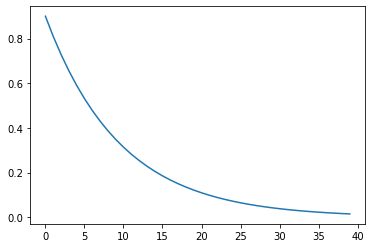

In [136]:
recorder = {"epsode":[],"epsilon":[]}

for epsode in range(EPISODES):
    if epsilon > MIN_EPSILON:
        epsilon *= EPSILON_DECAY
        epsilon = max(MIN_EPSILON, epsilon)
    
    recorder["epsode"].append(epsode)
    recorder["epsilon"].append(epsilon)

plt.plot(recorder["epsode"], recorder["epsilon"])

## 4) Create Model and set up environment


In [137]:
test.build_state_observation()
observation = test.state_observation

In [138]:
test.state_observation.shape

(2,)

In [139]:
test.build_state_observation()
observation = test.state_observation
def create_model():
    model = models.Sequential()

    #  model.add(Flatten(input_shape=(2,)))
    model.add(Dense(16 ,input_shape=(test.state_observation.shape)))
    model.add(Activation('relu'))
    model.add(Dense(16))
    model.add(Activation('relu'))
    model.add(Dense(16))
    model.add(Activation('relu'))
    model.add(Dense(ACTION_SPACE_SIZE))
    model.add(Activation('linear'))

    print(model.summary())

    model.compile(loss = 'mse', optimizer=Adam(lr=0.001),metrics=['accuracy'])

    return model


## 5) Create DQN Agent

In [140]:
class DQNAgent:

    def __init__(self):
    
        # Replay memory
        self.replay_memory = deque(maxlen=REPLAY_MEMORY_SIZE)

        # Prediction Network (the main Model)
        self.model_prediction = create_model()

        # Target Network
        self.model_target = create_model()
        self.model_target.set_weights(self.model_prediction.get_weights())

        # Used to count when to update target network with prediction network's weights
        self.target_update_counter = 0
    
  # Adds step's data to a memory replay array
  # (current_state, action, reward, next_state, done)
    def update_replay_memory(self, transition):
        self.replay_memory.append(transition)
  
  
  
  # Queries prediction network for Q values given current observation space (environment state)
    def get_qs(self, state):
        return self.model_prediction.predict(np.array(state).reshape(-1, *state.shape))[0]
  
    def train(self, terminal_state, step):
        if len(self.replay_memory) < MIN_REPLAY_MEMORY_SIZE:
            return
    
        minibatch = random.sample(self.replay_memory, MINIBATCH_SIZE)

        # Get current states from minibatch, then query NN model_prediction for current Q values
        current_states = np.array([transition[0] for transition in minibatch])
        current_qs_list = self.model_prediction.predict(current_states)   

        # Get next_states from minibatch, then query NN model_target for target Q values
        # When using target network, query it, otherwise main network should be queried
        next_states = np.array([transition[3] for transition in minibatch])
        target_qs_list = self.model_target.predict(next_states)

        X = []
        y = []

        # Now we need to enumerate our batches
        for index, (current_state, action, reward, next_state, done) in enumerate(minibatch):

            # If not a terminal state, get new q from future states, otherwise set it to 0
            # almost like with Q Learning, but we use just part of equation here
            if not done:
                max_target_q = np.max(target_qs_list[index])
                new_q = reward + DISCOUNT * max_target_q
            else:
                new_q = reward

            # Update Q value for given state
            current_qs = current_qs_list[index]
            current_qs[action] = new_q

            # And append to our training data
            X.append(current_state)
            y.append(current_qs)    

        # Fit on all samples as one batch, log only on terminal state
        self.model_prediction.fit(np.array(X), np.array(y), batch_size=MINIBATCH_SIZE, verbose=0, shuffle=False if terminal_state else None)

        # Update target network counter every episode
        if terminal_state:
            self.target_update_counter +=1

        # If counter reaches set value, update target network with weights of main network
        if self.target_update_counter > UPDATE_TARGET_EVERY:
            self.model_target.set_weights(self.model_prediction.get_weights())
            self.target_update_counter = 0

## 6) Initialize DroneLab Environment

In [141]:
port = 8007
test = DroneLabRL(port)
test.initialize_enviornment()

test.build_state_observation()


<ipykernel.iostream.OutStream object at 0x7f4c1c5dc2e0> connecting to localhost port 8007


## 7) Initialize DQN Agent

In [142]:
agent = DQNAgent()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_48 (Dense)            (None, 16)                48        
                                                                 
 activation_48 (Activation)  (None, 16)                0         
                                                                 
 dense_49 (Dense)            (None, 16)                272       
                                                                 
 activation_49 (Activation)  (None, 16)                0         
                                                                 
 dense_50 (Dense)            (None, 16)                272       
                                                                 
 activation_50 (Activation)  (None, 16)                0         
                                                                 
 dense_51 (Dense)            (None, 1891)            

## 8) Train the Agent 

##     time_step_length_seconds = num seconds to run dronelab. 


In [143]:
aggr_ep_rewards = {'ep':[],'avg':[],'min':[],'max':[]}

In [144]:
# Iterate over episodes
for episode in tqdm(range(1, EPISODES + 1), ascii=True, unit='episodes'):

    # Restarting episode - reset episode reward and step number
    episode_reward = 0
    step = 1

    # Reset environment and get initial state
    #current_state = env.reset()
    ##reset the environment
    port = 8007
    test = DroneLabRL(port)
    test.initialize_enviornment()
    test.time_step_length_seconds=15
    
    #observation = test.swarm_observation_space
    test.build_state_observation()
    current_state = test.state_observation  # num ppl, num ppl found

    # Reset flag and start iterating until episode ends
    while not test.done:
        # This part stays mostly the same, the change is to query a model for Q values
        if np.random.random() > epsilon:
            # Get action from Q table
            test.rl_action_to_take = np.argmax(agent.get_qs(current_state))
            #set the self.action_dict to the particular role
            test.select_rl_action()
        else:
            # Get random action
            test.select_random_action()
            
        #######step######
        test.step()
        test.get_swarm_roles()
        next_state = test.state_observation 
        reward = test.state_df.iloc[-1]['reward']
        print("************")
        
        print(test.state_df.iloc[-1]['num_survivors_found'] / test.state_df.iloc[-1]['initial_num_survivors'])
        print("************")

        #next_state, reward, done, _ = env.step(action)

        # Transform new continous state to new discrete state and count reward
        episode_reward += reward

#         if SHOW_PREVIEW and not episode % AGGREGATE_STATS_EVERY:
#             env.render()

        # Every step we update replay memory and train main network
        agent.update_replay_memory((current_state, test.rl_action_to_take, reward, next_state, test.done))
        agent.train(test.done, step)

        current_state = next_state
        step += 1

    # Append episode reward to a list and log rewards (every given number of episodes)
    ep_rewards.append(episode_reward)
    if not episode % AGGREGATE_STATS_EVERY or episode == 1:
        average_reward = sum(ep_rewards[-AGGREGATE_STATS_EVERY:])/len(ep_rewards[-AGGREGATE_STATS_EVERY:])
        min_reward = min(ep_rewards[-AGGREGATE_STATS_EVERY:])
        max_reward = max(ep_rewards[-AGGREGATE_STATS_EVERY:])
        
        aggr_ep_rewards['ep'].append(episode)
        aggr_ep_rewards['avg'].append(average_reward)
        aggr_ep_rewards['min'].append(min_reward)
        aggr_ep_rewards['max'].append(max_reward)
        
#         agent.tensorboard.update_stats(reward_avg=average_reward, reward_min=min_reward, reward_max=max_reward, epsilon=epsilon)

        # Save model, but only when min reward is greater or equal a set value
#         if min_reward >= MIN_REWARD:
#             agent.model.save(f'models/{MODEL_NAME}__{max_reward:_>7.2f}max_{average_reward:_>7.2f}avg_{min_reward:_>7.2f}min__{int(time.time())}.model')

    # Decay epsilon
    if epsilon > MIN_EPSILON:
        epsilon *= EPSILON_DECAY
        epsilon = max(MIN_EPSILON, epsilon)


  0%|          | 0/40 [00:00<?, ?episodes/s]

<ipykernel.iostream.OutStream object at 0x7f4c1c5dc2e0> connecting to localhost port 8007
************
0.012307692307692308
************
************
0.04923076923076923
************
************
0.10615384615384615
************
************
0.17384615384615384
************
************
0.21846153846153846
************
************
0.25384615384615383
************


  2%|2         | 1/40 [01:58<1:17:17, 118.91s/episodes]

************
0.3707692307692308
************
<ipykernel.iostream.OutStream object at 0x7f4c1c5dc2e0> connecting to localhost port 8007
************
0.013846153846153847
************
************
0.07538461538461538
************
************
0.11692307692307692
************
************
0.15692307692307692
************
************
0.21384615384615385
************
************
0.23846153846153847
************
************
0.27384615384615385
************


  5%|5         | 2/40 [04:14<1:18:30, 123.96s/episodes]

************
0.3230769230769231
************
<ipykernel.iostream.OutStream object at 0x7f4c1c5dc2e0> connecting to localhost port 8007
************
0.007692307692307693
************
************
0.06153846153846154
************
************
0.1
************
************
0.12153846153846154
************
************
0.24615384615384617
************
************
0.28923076923076924
************


  8%|7         | 3/40 [06:13<1:15:30, 122.44s/episodes]

************
0.31846153846153846
************
<ipykernel.iostream.OutStream object at 0x7f4c1c5dc2e0> connecting to localhost port 8007
************
0.010769230769230769
************
************
0.05384615384615385
************
************
0.12
************
************
0.14461538461538462
************
************
0.16307692307692306
************
************
0.20307692307692307
************
************
0.25384615384615383
************
************
0.28307692307692306
************


 10%|#         | 4/40 [08:46<1:18:53, 131.48s/episodes]

************
0.3446153846153846
************
<ipykernel.iostream.OutStream object at 0x7f4c1c5dc2e0> connecting to localhost port 8007
************
0.010769230769230769
************
************
0.046153846153846156
************
************
0.11384615384615385
************
************
0.13538461538461538
************
************
0.18461538461538463
************
************
0.22153846153846155
************
************
0.24615384615384617
************
************
0.29384615384615387
************


 12%|#2        | 5/40 [11:18<1:20:21, 137.77s/episodes]

************
0.4046153846153846
************
<ipykernel.iostream.OutStream object at 0x7f4c1c5dc2e0> connecting to localhost port 8007
************
0.02
************
************
0.06307692307692307
************
************
0.10615384615384615
************
************
0.1523076923076923
************
************
0.19692307692307692
************
************
0.2353846153846154
************


 15%|#5        | 6/40 [13:17<1:14:51, 132.10s/episodes]

************
0.33692307692307694
************
<ipykernel.iostream.OutStream object at 0x7f4c1c5dc2e0> connecting to localhost port 8007
************
0.018461538461538463
************
************
0.1
************
************
0.16153846153846155
************
************
0.19538461538461538
************
************
0.24307692307692308
************


 18%|#7        | 7/40 [14:59<1:07:42, 123.10s/episodes]

************
0.33384615384615385
************
<ipykernel.iostream.OutStream object at 0x7f4c1c5dc2e0> connecting to localhost port 8007
************
0.010769230769230769
************
************
0.04461538461538461
************
************
0.09384615384615384
************
************
0.12923076923076923
************
************
0.16307692307692306
************
************
0.18923076923076923
************
************
0.21846153846153846
************
************
0.26153846153846155
************
************
0.2923076923076923
************


 20%|##        | 8/40 [17:48<1:13:03, 136.99s/episodes]

************
0.3123076923076923
************
<ipykernel.iostream.OutStream object at 0x7f4c1c5dc2e0> connecting to localhost port 8007
************
0.007692307692307693
************
************
0.04153846153846154
************
************
0.0876923076923077
************
************
0.16307692307692306
************
************
0.2076923076923077
************


 22%|##2       | 9/40 [19:31<1:05:22, 126.52s/episodes]

************
0.32153846153846155
************
<ipykernel.iostream.OutStream object at 0x7f4c1c5dc2e0> connecting to localhost port 8007
************
0.007692307692307693
************
************
0.047692307692307694
************
************
0.09846153846153846
************
************
0.15384615384615385
************
************
0.18
************
************
0.2123076923076923
************
************
0.2630769230769231
************
************
0.28615384615384615
************


 25%|##5       | 10/40 [22:03<1:07:10, 134.36s/episodes]

************
0.3169230769230769
************
<ipykernel.iostream.OutStream object at 0x7f4c1c5dc2e0> connecting to localhost port 8007
************
0.010769230769230769
************
************
0.05384615384615385
************
************
0.11076923076923077
************
************
0.16153846153846155
************
************
0.19692307692307692
************
************
0.22153846153846155
************
************
0.26
************
************
0.2907692307692308
************


 28%|##7       | 11/40 [24:36<1:07:35, 139.83s/episodes]

************
0.3630769230769231
************
<ipykernel.iostream.OutStream object at 0x7f4c1c5dc2e0> connecting to localhost port 8007
************
0.013846153846153847
************
************
0.07384615384615385
************
************
0.11076923076923077
************
************
0.14307692307692307
************
************
0.2076923076923077
************
************
0.22923076923076924
************
************
0.26615384615384613
************


 30%|###       | 12/40 [26:52<1:04:41, 138.61s/episodes]

************
0.3169230769230769
************
<ipykernel.iostream.OutStream object at 0x7f4c1c5dc2e0> connecting to localhost port 8007
************
0.009230769230769232
************
************
0.05846153846153846
************
************
0.09538461538461539
************
************
0.18307692307692308
************
************
0.28615384615384615
************


 32%|###2      | 13/40 [28:34<57:27, 127.67s/episodes]  

************
0.31846153846153846
************
<ipykernel.iostream.OutStream object at 0x7f4c1c5dc2e0> connecting to localhost port 8007
************
0.012307692307692308
************
************
0.05384615384615385
************
************
0.09384615384615384
************
************
0.12153846153846154
************
************
0.16
************
************
0.20615384615384616
************
************
0.22923076923076924
************
************
0.26461538461538464
************


 35%|###5      | 14/40 [31:06<58:34, 135.16s/episodes]

************
0.3569230769230769
************
<ipykernel.iostream.OutStream object at 0x7f4c1c5dc2e0> connecting to localhost port 8007
************
0.012307692307692308
************
************
0.06769230769230769
************
************
0.12
************
************
0.15846153846153846
************
************
0.1753846153846154
************
************
0.19384615384615383
************
************
0.2153846153846154
************
************
0.2692307692307692
************
************
0.2953846153846154
************


 38%|###7      | 15/40 [33:56<1:00:35, 145.44s/episodes]

************
0.37846153846153846
************
<ipykernel.iostream.OutStream object at 0x7f4c1c5dc2e0> connecting to localhost port 8007
************
0.013846153846153847
************
************
0.04923076923076923
************
************
0.13076923076923078
************
************
0.17384615384615384
************
************
0.20307692307692307
************


 40%|####      | 16/40 [35:38<52:58, 132.45s/episodes]  

************
0.33384615384615385
************
<ipykernel.iostream.OutStream object at 0x7f4c1c5dc2e0> connecting to localhost port 8007
************
0.007692307692307693
************
************
0.05076923076923077
************
************
0.10461538461538461
************
************
0.14461538461538462
************
************
0.18307692307692308
************
************
0.2276923076923077
************
************
0.2784615384615385
************


 42%|####2     | 17/40 [37:54<51:09, 133.46s/episodes]

************
0.3353846153846154
************
<ipykernel.iostream.OutStream object at 0x7f4c1c5dc2e0> connecting to localhost port 8007
************
0.018461538461538463
************
************
0.052307692307692305
************
************
0.10153846153846154
************
************
0.16153846153846155
************
************
0.19076923076923077
************
************
0.2230769230769231
************
************
0.27076923076923076
************


 45%|####5     | 18/40 [40:10<49:13, 134.27s/episodes]

************
0.3169230769230769
************
<ipykernel.iostream.OutStream object at 0x7f4c1c5dc2e0> connecting to localhost port 8007
************
0.012307692307692308
************
************
0.02923076923076923
************
************
0.08307692307692308
************
************
0.13230769230769232
************
************
0.19846153846153847
************
************
0.22153846153846155
************
************
0.29384615384615387
************


 48%|####7     | 19/40 [42:26<47:09, 134.74s/episodes]

************
0.36615384615384616
************
<ipykernel.iostream.OutStream object at 0x7f4c1c5dc2e0> connecting to localhost port 8007
************
0.016923076923076923
************
************
0.05846153846153846
************
************
0.09076923076923077
************
************
0.14461538461538462
************
************
0.16615384615384615
************
************
0.20923076923076922
************
************
0.24615384615384617
************
************
0.2876923076923077
************


 50%|#####     | 20/40 [44:58<46:42, 140.13s/episodes]

************
0.33076923076923076
************
<ipykernel.iostream.OutStream object at 0x7f4c1c5dc2e0> connecting to localhost port 8007
************
0.015384615384615385
************
************
0.055384615384615386
************
************
0.09384615384615384
************
************
0.13076923076923078
************
************
0.15076923076923077
************
************
0.1753846153846154
************
************
0.20307692307692307
************
************
0.24461538461538462
************
************
0.2907692307692308
************


 52%|#####2    | 21/40 [47:48<47:09, 148.93s/episodes]

************
0.3030769230769231
************
<ipykernel.iostream.OutStream object at 0x7f4c1c5dc2e0> connecting to localhost port 8007
************
0.015384615384615385
************
************
0.06
************
************
0.11384615384615385
************
************
0.13846153846153847
************
************
0.17692307692307693
************
************
0.21076923076923076
************
************
0.23692307692307693
************
************
0.27384615384615385
************


 55%|#####5    | 22/40 [50:21<45:00, 150.04s/episodes]

************
0.32153846153846155
************
<ipykernel.iostream.OutStream object at 0x7f4c1c5dc2e0> connecting to localhost port 8007
************
0.013846153846153847
************
************
0.06769230769230769
************
************
0.11076923076923077
************
************
0.15692307692307692
************
************
0.18307692307692308
************
************
0.19384615384615383
************
************
0.2169230769230769
************
************
0.2753846153846154
************
************
0.2969230769230769
************


 57%|#####7    | 23/40 [53:10<44:09, 155.88s/episodes]

************
0.30615384615384617
************
<ipykernel.iostream.OutStream object at 0x7f4c1c5dc2e0> connecting to localhost port 8007
************
0.010769230769230769
************
************
0.06769230769230769
************
************
0.10461538461538461
************
************
0.15692307692307692
************
************
0.19846153846153847
************
************
0.24923076923076923
************
************
0.26615384615384613
************
************
0.2876923076923077
************


 60%|######    | 24/40 [55:43<41:18, 154.92s/episodes]

************
0.4492307692307692
************
<ipykernel.iostream.OutStream object at 0x7f4c1c5dc2e0> connecting to localhost port 8007
************
0.009230769230769232
************
************
0.024615384615384615
************
************
0.0876923076923077
************
************
0.1723076923076923
************
************
0.22615384615384615
************
************
0.24923076923076923
************
************
0.27384615384615385
************


 62%|######2   | 25/40 [57:59<37:18, 149.21s/episodes]

************
0.30615384615384617
************
<ipykernel.iostream.OutStream object at 0x7f4c1c5dc2e0> connecting to localhost port 8007
************
0.010769230769230769
************
************
0.03538461538461538
************
************
0.06923076923076923
************
************
0.11846153846153847
************
************
0.1646153846153846
************
************
0.18307692307692308
************
************
0.21384615384615385
************
************
0.24615384615384617
************


 65%|######5   | 26/40 [1:00:31<35:03, 150.25s/episodes]

************
0.32153846153846155
************
<ipykernel.iostream.OutStream object at 0x7f4c1c5dc2e0> connecting to localhost port 8007
************
0.009230769230769232
************
************
0.03538461538461538
************
************
0.08615384615384615
************
************
0.14461538461538462
************
************
0.16
************
************
0.18307692307692308
************
************
0.20923076923076922
************
************
0.2276923076923077
************
************
0.25384615384615383
************
************
0.28923076923076924
************


 68%|######7   | 27/40 [1:03:38<34:53, 161.08s/episodes]

************
0.32769230769230767
************
<ipykernel.iostream.OutStream object at 0x7f4c1c5dc2e0> connecting to localhost port 8007
************
0.006153846153846154
************
************
0.024615384615384615
************
************
0.07230769230769231
************
************
0.09538461538461539
************
************
0.12461538461538461
************
************
0.16615384615384615
************
************
0.18615384615384614
************
************
0.21076923076923076
************
************
0.24153846153846154
************
************
0.2876923076923077
************


 70%|#######   | 28/40 [1:06:44<33:43, 168.66s/episodes]

************
0.3153846153846154
************
<ipykernel.iostream.OutStream object at 0x7f4c1c5dc2e0> connecting to localhost port 8007
************
0.009230769230769232
************
************
0.03538461538461538
************
************
0.06
************
************
0.1076923076923077
************
************
0.14307692307692307
************
************
0.18307692307692308
************
************
0.20923076923076922
************
************
0.22
************


 72%|#######2  | 29/40 [1:09:17<30:02, 163.87s/episodes]

************
0.3030769230769231
************
<ipykernel.iostream.OutStream object at 0x7f4c1c5dc2e0> connecting to localhost port 8007
************
0.006153846153846154
************
************
0.043076923076923075
************
************
0.07692307692307693
************
************
0.11692307692307692
************
************
0.1676923076923077
************
************
0.20307692307692307
************
************
0.22615384615384615
************
************
0.2569230769230769
************
************
0.2923076923076923
************


 75%|#######5  | 30/40 [1:12:06<27:35, 165.58s/episodes]

************
0.3030769230769231
************
<ipykernel.iostream.OutStream object at 0x7f4c1c5dc2e0> connecting to localhost port 8007
************
0.009230769230769232
************
************
0.05076923076923077
************
************
0.10153846153846154
************
************
0.13846153846153847
************
************
0.23384615384615384
************


 78%|#######7  | 31/40 [1:13:48<21:59, 146.56s/episodes]

************
0.4307692307692308
************
<ipykernel.iostream.OutStream object at 0x7f4c1c5dc2e0> connecting to localhost port 8007
************
0.010769230769230769
************
************
0.023076923076923078
************
************
0.08615384615384615
************
************
0.12
************
************
0.14307692307692307
************
************
0.16153846153846155
************
************
0.17692307692307693
************
************
0.20153846153846153
************
************
0.23076923076923078
************
************
0.26
************


 80%|########  | 32/40 [1:16:55<21:08, 158.53s/episodes]

************
0.30153846153846153
************
<ipykernel.iostream.OutStream object at 0x7f4c1c5dc2e0> connecting to localhost port 8007
************
0.009230769230769232
************
************
0.02923076923076923
************
************
0.11076923076923077
************
************
0.1646153846153846
************
************
0.19692307692307692
************
************
0.2246153846153846
************
************
0.24615384615384617
************
************
0.2676923076923077
************
************
0.2923076923076923
************


 82%|########2 | 33/40 [1:19:44<18:52, 161.81s/episodes]

************
0.35384615384615387
************
<ipykernel.iostream.OutStream object at 0x7f4c1c5dc2e0> connecting to localhost port 8007
************
0.007692307692307693
************
************
0.038461538461538464
************
************
0.08461538461538462
************
************
0.1276923076923077
************
************
0.20461538461538462
************
************
0.24769230769230768
************
************
0.2692307692307692
************
************
0.2907692307692308
************


 85%|########5 | 34/40 [1:22:17<15:54, 159.07s/episodes]

************
0.32769230769230767
************
<ipykernel.iostream.OutStream object at 0x7f4c1c5dc2e0> connecting to localhost port 8007
************
0.006153846153846154
************
************
0.023076923076923078
************
************
0.04923076923076923
************
************
0.10615384615384615
************
************
0.13846153846153847
************
************
0.1676923076923077
************
************
0.18615384615384614
************
************
0.24153846153846154
************
************
0.27692307692307694
************


 88%|########7 | 35/40 [1:25:07<13:31, 162.23s/episodes]

************
0.34923076923076923
************
<ipykernel.iostream.OutStream object at 0x7f4c1c5dc2e0> connecting to localhost port 8007
************
0.012307692307692308
************
************
0.03230769230769231
************
************
0.052307692307692305
************
************
0.09384615384615384
************
************
0.13076923076923078
************
************
0.23076923076923078
************
************
0.29384615384615387
************


 90%|######### | 36/40 [1:27:22<10:17, 154.32s/episodes]

************
0.3292307692307692
************
<ipykernel.iostream.OutStream object at 0x7f4c1c5dc2e0> connecting to localhost port 8007
************
0.015384615384615385
************
************
0.03230769230769231
************
************
0.08307692307692308
************
************
0.14
************
************
0.1676923076923077
************
************
0.2630769230769231
************
************
0.2923076923076923
************


 92%|#########2| 37/40 [1:29:38<07:26, 148.78s/episodes]

************
0.31384615384615383
************
<ipykernel.iostream.OutStream object at 0x7f4c1c5dc2e0> connecting to localhost port 8007
************
0.010769230769230769
************
************
0.03076923076923077
************
************
0.08923076923076922
************
************
0.11692307692307692
************
************
0.14923076923076922
************
************
0.18
************
************
0.20307692307692307
************
************
0.22
************
************
0.24615384615384617
************
************
0.2815384615384615
************


 95%|#########5| 38/40 [1:32:45<05:20, 160.08s/episodes]

************
0.32153846153846155
************
<ipykernel.iostream.OutStream object at 0x7f4c1c5dc2e0> connecting to localhost port 8007
************
0.006153846153846154
************
************
0.012307692307692308
************
************
0.055384615384615386
************
************
0.09230769230769231
************
************
0.14461538461538462
************
************
0.18153846153846154
************
************
0.20461538461538462
************
************
0.2553846153846154
************


 98%|#########7| 39/40 [1:35:18<02:37, 157.88s/episodes]

************
0.3292307692307692
************
<ipykernel.iostream.OutStream object at 0x7f4c1c5dc2e0> connecting to localhost port 8007
************
0.010769230769230769
************
************
0.02923076923076923
************
************
0.07538461538461538
************
************
0.1076923076923077
************
************
0.14153846153846153
************
************
0.16307692307692306
************
************
0.18153846153846154
************
************
0.19846153846153847
************
************
0.24307692307692308
************
************
0.27692307692307694
************


100%|##########| 40/40 [1:38:24<00:00, 147.61s/episodes]

************
0.3123076923076923
************


## Plot rewards

Text(0, 0.5, 'Rewards')

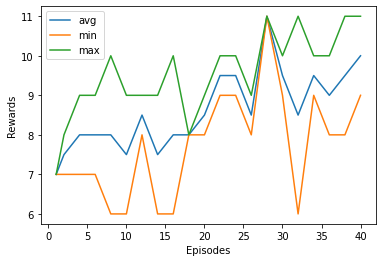

In [145]:
plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['avg'], label = 'avg')
plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['min'], label = 'min')
plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['max'], label = 'max')
plt.legend(loc='upper left')
plt.xlabel('Episodes')
plt.ylabel('Rewards')